# Определение стоимости автомобилей

## Цели и ход исследования

В данном исследовании мы проанализируем исторические данные о проданных автомобилях: технические характеристики, комплектации и цены. 

**Цель исследования**:
Построить модель, которая умеет предсказывать рыночную стоимость автомобиля. 

**Ход исследования**:
- Подготовка данных
- Обучение моделей
- Анализ моделей

## Подготовка данных

In [37]:
# Импортируем библиотеки
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

!pip install phik
import phik

from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.compose import make_column_transformer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.linear_model import LinearRegression, ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.dummy import DummyRegressor

!pip install optuna
import optuna

import lightgbm as lgb

!pip install catboost
from catboost import CatBoostRegressor, Pool

import warnings; warnings.filterwarnings('ignore')

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


### Открытие файла и изучение данных

In [14]:
# Открываем файл
try:
    df = pd.read_csv('/content/autos.csv')
except:
    df = pd.read_csv('https://code.s3.yandex.net/datasets/autos.csv')

In [15]:
# Изучаем информацию
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  Repaired           283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

In [7]:
df.head(10)

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480.0,NaN,1993.0,manual,0.0,golf,150000.0,0.0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0.0,70435.0,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300.0,coupe,2011.0,manual,190.0,NaN,125000.0,5.0,gasoline,audi,yes,2016-03-24 00:00:00,0.0,66954.0,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800.0,suv,2004.0,auto,163.0,grand,125000.0,8.0,gasoline,jeep,NaN,2016-03-14 00:00:00,0.0,90480.0,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500.0,small,2001.0,manual,75.0,golf,150000.0,6.0,petrol,volkswagen,no,2016-03-17 00:00:00,0.0,91074.0,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600.0,small,2008.0,manual,69.0,fabia,90000.0,7.0,gasoline,skoda,no,2016-03-31 00:00:00,0.0,60437.0,2016-04-06 10:17:21
5,2016-04-04 17:36:23,650.0,sedan,1995.0,manual,102.0,3er,150000.0,10.0,petrol,bmw,yes,2016-04-04 00:00:00,0.0,33775.0,2016-04-06 19:17:07
6,2016-04-01 20:48:51,2200.0,convertible,2004.0,manual,109.0,2_reihe,150000.0,8.0,petrol,peugeot,no,2016-04-01 00:00:00,0.0,67112.0,2016-04-05 18:18:39
7,2016-03-21 18:54:38,0.0,sedan,1980.0,manual,50.0,other,40000.0,7.0,petrol,volkswagen,no,2016-03-21 00:00:00,0.0,19348.0,2016-03-25 16:47:58
8,2016-04-04 23:42:13,14500.0,bus,2014.0,manual,125.0,c_max,30000.0,8.0,petrol,ford,NaN,2016-04-04 00:00:00,0.0,94505.0,2016-04-04 23:42:13
9,2016-03-17 10:53:50,999.0,small,1998.0,manual,101.0,golf,150000.0,0.0,NaN,volkswagen,NaN,2016-03-17 00:00:00,0.0,27472.0,2016-03-31 17:17:06


В  датасете  **354369** строк и **16** столбцов. 

Семь столбцов имеют тип данных *int64*, девять столбцов - тип данных *object*. 

Данные столбца `Price`, который является целевым признаком, относятся к количественным, значит в ходе машинного обучения будет решатся задача регрессии.

### Взаимосвязь признаков

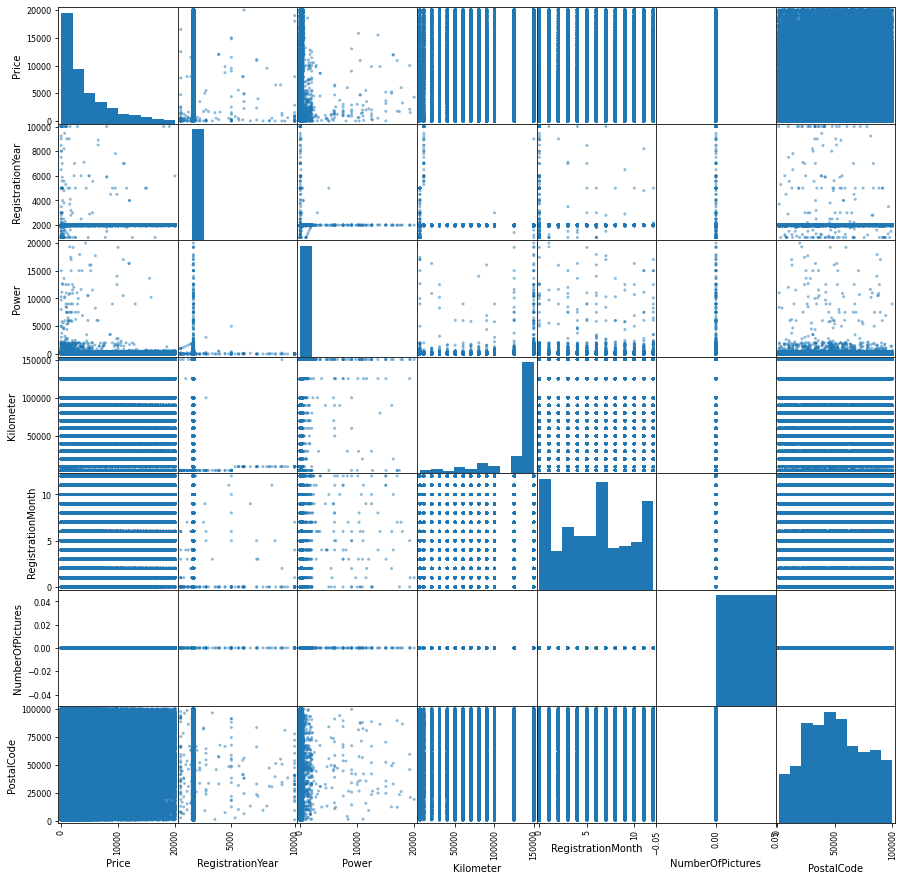

In [ ]:
# Построим матрицу диаграмм рассеяния:
pd.plotting.scatter_matrix(df, figsize=(15, 15));

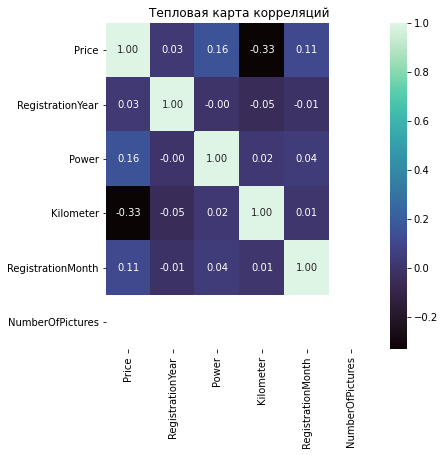

In [ ]:
# Построим хитмэп корреляций Пирсона для численных признаков
plt.figure(figsize = (6,6))
sns.heatmap(df[['Price', 'RegistrationYear', 'Power', 'Kilometer', 'RegistrationMonth', 'NumberOfPictures']].corr(), annot = True, cmap = 'mako', fmt = '.2f')
plt.title('Тепловая карта корреляций')
plt.show()

In [ ]:
interval_cols = ['Price', 'RegistrationYear', 'Power', 'Kilometer', 'RegistrationMonth']

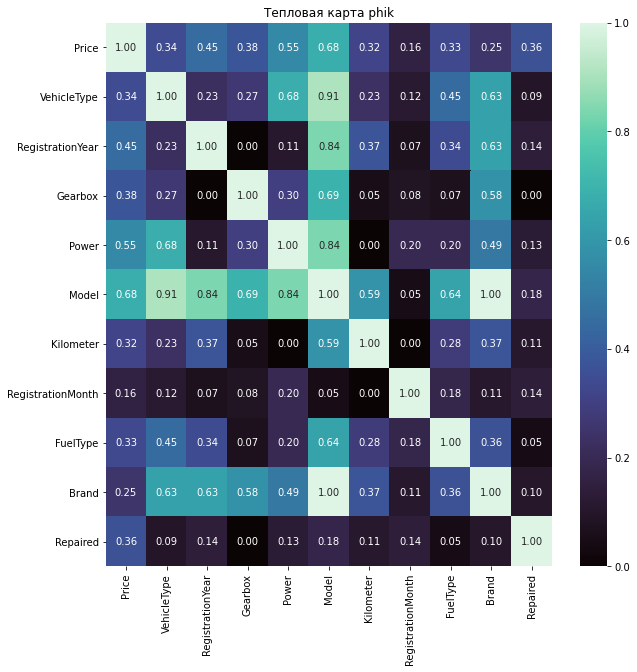

In [ ]:
# Построим хитмэп корреляций phik

plt.figure(figsize = (10,10))
sns.heatmap(df.drop(['DateCrawled', 'DateCreated', 'PostalCode', 'LastSeen'], axis = 1)
            .sample(1000).phik_matrix(interval_cols=interval_cols), 
            annot = True, 
            cmap = 'mako', 
            fmt = '.2f')
plt.title('Тепловая карта phik')
plt.show()

Сильных корреляций между численными признаками не обнаружено.

В категориальных признаках ожидаемо обнаружилились сильные взаимосвязи между брендом и моделью и между моделью и типом кузова.

### Дубликаты

In [16]:
# Проверим на наличие дубликатов
df.duplicated().sum()

4

In [17]:
# Удалим дубликаты
df = df.drop_duplicates() 

In [10]:
df.duplicated().sum()

0

In [18]:
# Проверим, есть ли неявные дубликаты 
df['FuelType'].value_counts()

petrol      216349
gasoline     98719
lpg           5310
cng            565
hybrid         233
other          204
electric        90
Name: FuelType, dtype: int64

`Petrol` и `gasoline` - это разные названия одного и того же топлива - бензина. Заменим все на `petrol`.

In [19]:
df.loc[df['FuelType'] == 'gasoline', 'FuelType'] = 'petrol'

In [20]:
df['FuelType'].value_counts()

petrol      315068
lpg           5310
cng            565
hybrid         233
other          204
electric        90
Name: FuelType, dtype: int64

### Пропуски

In [21]:
# Проверим наличие пропусков
df.isna().sum().sort_values(ascending = False)

Repaired             71154
VehicleType          37490
FuelType             32895
Gearbox              19833
Model                19705
DateCrawled              0
Price                    0
RegistrationYear         0
Power                    0
Kilometer                0
RegistrationMonth        0
Brand                    0
DateCreated              0
NumberOfPictures         0
PostalCode               0
LastSeen                 0
dtype: int64

In [22]:
pd.DataFrame(df
             .isna()
             .mean()
             .sort_values(ascending = False).head()*100).round(2).style.background_gradient('coolwarm')

,0
Repaired,20.080000
VehicleType,10.580000
FuelType,9.280000
Gearbox,5.600000
Model,5.560000


В датасете очень много пропусков. 

In [23]:
# Удалим столбец 'Repaired', так как информации для заполнения данных нет
df = df.drop('Repaired', axis = 1)

In [24]:
# Также удалим столбец 'VehicleType'. Он сильно коррелирует с 'Model', это может повлиять на качество модели
df = df.drop('VehicleType', axis = 1)

In [25]:
# Остальные столбцы заполним занчениями 'uknown'
df['FuelType'] = df['FuelType'].fillna('uknown')

In [26]:
df['Gearbox'] = df['Gearbox'].fillna('uknown') 

In [27]:
df['Model'] = df['Model'].fillna('uknown') 

In [28]:
df.isna().sum().sort_values(ascending = False)

DateCrawled          0
Price                0
RegistrationYear     0
Gearbox              0
Power                0
Model                0
Kilometer            0
RegistrationMonth    0
FuelType             0
Brand                0
DateCreated          0
NumberOfPictures     0
PostalCode           0
LastSeen             0
dtype: int64

### Аномалии

Изучим содержимое столбцов на графиках. 

#### Цена

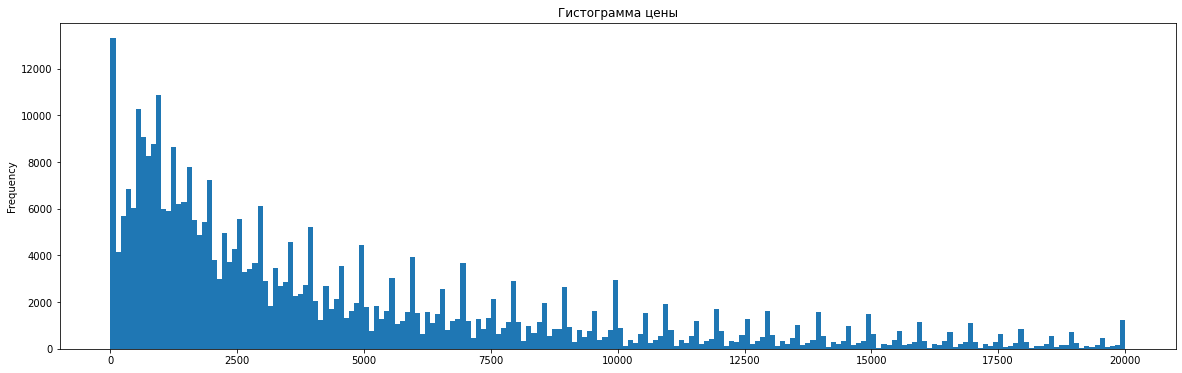

In [ ]:
df['Price'].plot(kind = 'hist', bins = 200, figsize = (20,6), title = 'Гистограмма цены');

На гистрограмме видно, что распределение цены скошено вправо. Локальные пики приходятся на круглые суммы. Максимальный пик - в районе нуля.

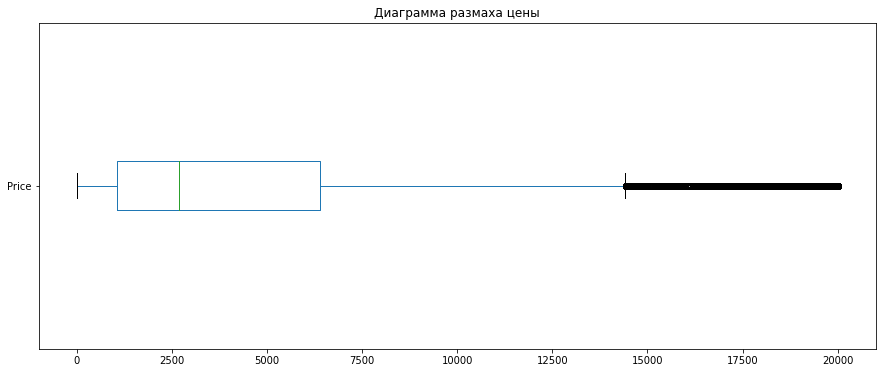

In [ ]:
df['Price'].plot.box(figsize = (15,6), vert = False, title = 'Диаграмма размаха цены');

In [ ]:
df['Price'].describe()

count    354365.000000
mean       4416.679830
std        4514.176349
min           0.000000
25%        1050.000000
50%        2700.000000
75%        6400.000000
max       20000.000000
Name: Price, dtype: float64

**75%** цен не привышают **6400** евро. Медиана находится на уровне **2700**, среднее - **4417** евро. Минимальная цена **0** евро. Максимальная - **20 000**.

In [ ]:
# Посмотрим, сколько машин стоят 0 евро
df.loc[df['Price'] == 0, 'Price'].count()

10772

In [ ]:
df.loc[df['Price'] == 0, 'Price'].count()/df.shape[0]

0.030398035923412302

In [29]:
# Удалим строки с нулевыми значениями цены, они ничему не научат модель
df = df.loc[df['Price'] != 0]

In [30]:
df.loc[df['Price'] == 0, 'Price'].count()

0

#### Даты

Посмотрим на столбцы с датами

In [ ]:
df['DateCrawled'] = df['DateCrawled'].astype('datetime64')

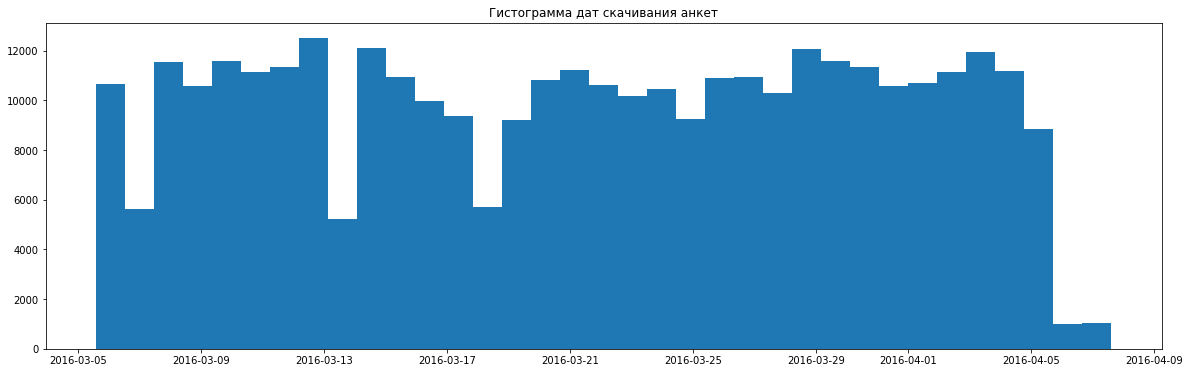

In [ ]:
plt.figure(figsize = (20,6))
plt.hist(df['DateCrawled'] , bins = 35)
plt.title('Гистограмма дат скачивания анкет');

In [ ]:
df['DateCrawled'].describe()

count                  343593
unique                 265135
top       2016-03-24 14:49:47
freq                        7
first     2016-03-05 14:06:22
last      2016-04-07 14:36:58
Name: DateCrawled, dtype: object

In [31]:
df['DateCreated'] = df['DateCreated'].astype('datetime64') 

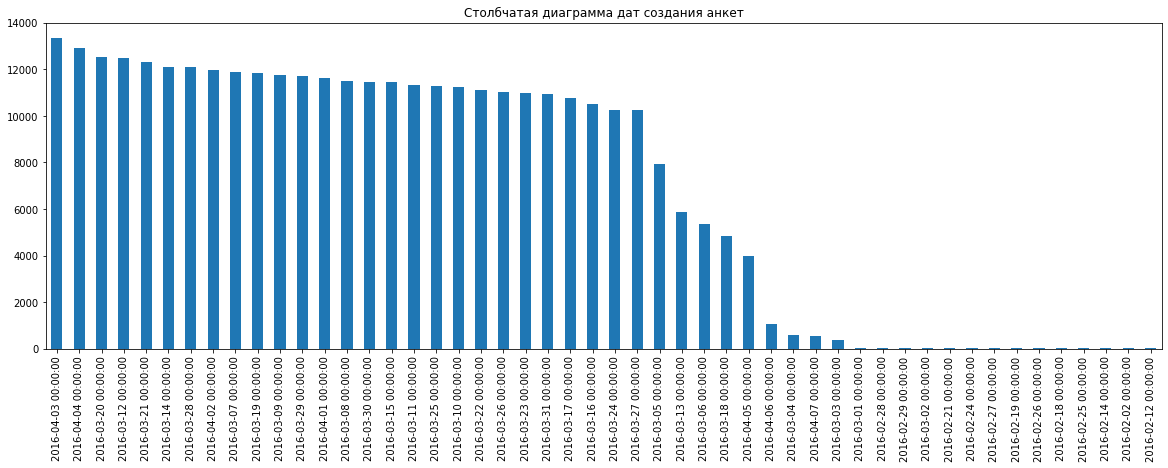

In [ ]:
df['DateCreated'].value_counts().head(50).plot(kind = 'bar',
                                               figsize = (20,6), 
                                               title = 'Столбчатая диаграмма дат создания анкет');

In [ ]:
df['DateCreated'].describe()

count                  343593
unique                    109
top       2016-04-03 00:00:00
freq                    13341
first     2014-03-10 00:00:00
last      2016-04-07 00:00:00
Name: DateCreated, dtype: object

In [32]:
df['LastSeen'] = df['LastSeen'].astype('datetime64') 

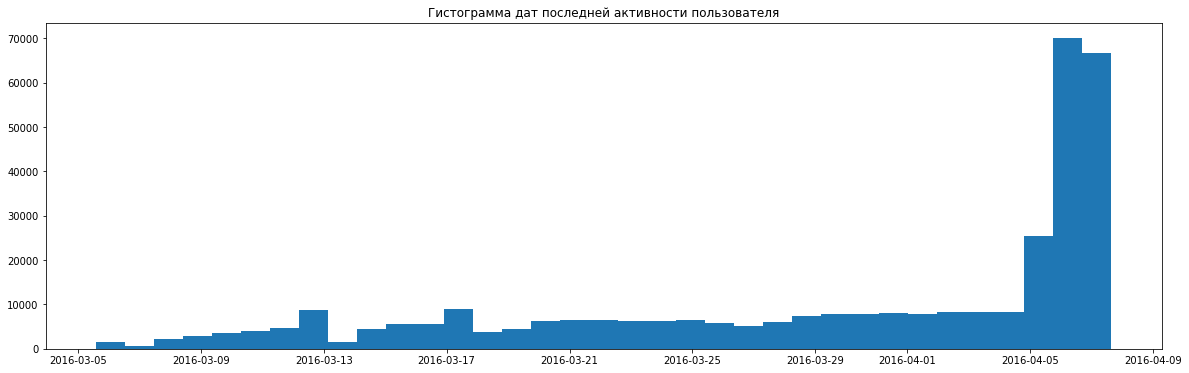

In [ ]:
plt.figure(figsize = (20,6))
plt.hist(df['LastSeen'] , bins = 35)
plt.title('Гистограмма дат последней активности пользователя');

In [ ]:
df['LastSeen'].describe()

count                  343593
unique                 174543
top       2016-04-06 09:46:00
freq                       16
first     2016-03-05 14:15:08
last      2016-04-07 14:58:51
Name: LastSeen, dtype: object

Все анкеты относятся к 2014-2016 гг. Последняя активность пользователя и дата скачивания анкеты относятся к марту-апрелю 2106 года. Данные столбцы неинформативны, поэтому из признакового пространства их можно исключить.

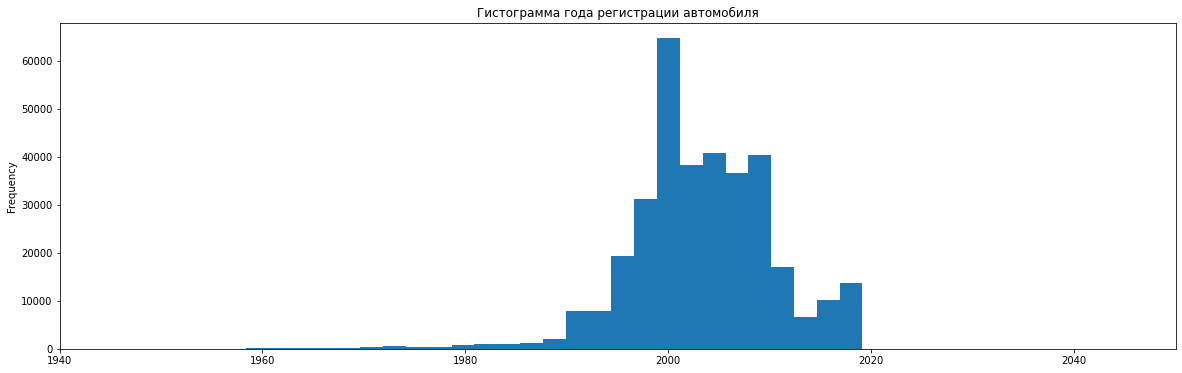

In [ ]:
df['RegistrationYear'].plot(kind = 'hist', 
                            bins = 4000,
                            figsize = (20,6), 
                            xlim = (1940,2050),
                            title = 'Гистограмма года регистрации автомобиля');

In [ ]:
df['RegistrationYear'].describe()

count    343593.00000
mean       2004.08983
std          78.41368
min        1000.00000
25%        1999.00000
50%        2003.00000
75%        2008.00000
max        9999.00000
Name: RegistrationYear, dtype: float64

In [ ]:
df.loc[df['RegistrationYear'] > 2016, 'RegistrationYear'].value_counts()

2017    9895
2018    3782
9999      18
2019      16
5000      16
3000       6
6000       5
7000       4
2500       3
4000       3
9000       2
5555       2
4500       2
5911       2
8000       2
9450       1
5900       1
4100       1
2222       1
3700       1
6500       1
2900       1
5300       1
8500       1
8888       1
8200       1
2200       1
7800       1
2290       1
2066       1
5600       1
4800       1
3800       1
3200       1
2800       1
7100       1
Name: RegistrationYear, dtype: int64

In [ ]:
df.loc[df['RegistrationYear'] > 2016, 'RegistrationYear'].count()

13779

In [ ]:
df.loc[df['RegistrationYear'] > 2016, 'RegistrationYear'].count()/len(df['RegistrationYear'])

0.040102679623857294

In [ ]:
df.loc[df['RegistrationYear'] < 1900, 'RegistrationYear'].value_counts()

1000    31
1800     5
1234     4
1500     3
1600     2
1300     2
1602     1
1039     1
1111     1
1255     1
1001     1
1400     1
Name: RegistrationYear, dtype: int64

In [ ]:
df.loc[df['RegistrationYear'] < 1900, 'RegistrationYear'].count()/len(df['RegistrationYear'])

0.0001542522694001333

**4%** анкет имеют аномально большие значения в поле `RegistrationYear`. Еще несколько дестков автомобилей были зарегистрированы в доавтомобильную эпоху. 

Заменим все эти значения нулями.

In [ ]:
df.loc[(df['RegistrationYear'] > 2016)|(df['RegistrationYear'] < 1900), 'RegistrationYear'] = 0

In [ ]:
df['RegistrationYear'].unique()

array([1993, 2011, 2004, 2001, 2008, 1995, 2014, 1998, 2005, 1910, 2016,
       2007, 2009, 2002,    0, 1997, 1990, 1981, 2003, 1994, 1991, 1984,
       2006, 1999, 2012, 2010, 2000, 1992, 2013, 1996, 1985, 1989, 2015,
       1982, 1976, 1983, 1973, 1969, 1971, 1987, 1986, 1988, 1980, 1970,
       1965, 1945, 1925, 1974, 1979, 1955, 1978, 1972, 1968, 1977, 1961,
       1966, 1975, 1963, 1964, 1960, 1958, 1967, 1959, 1956, 1941, 1962,
       1929, 1957, 1940, 1949, 1937, 1951, 1953, 1954, 1950, 1948, 1952,
       1932, 1942, 1935, 1933, 1936, 1923, 1930, 1944, 1943, 1934, 1938,
       1928, 1931, 1947, 1927, 1946])

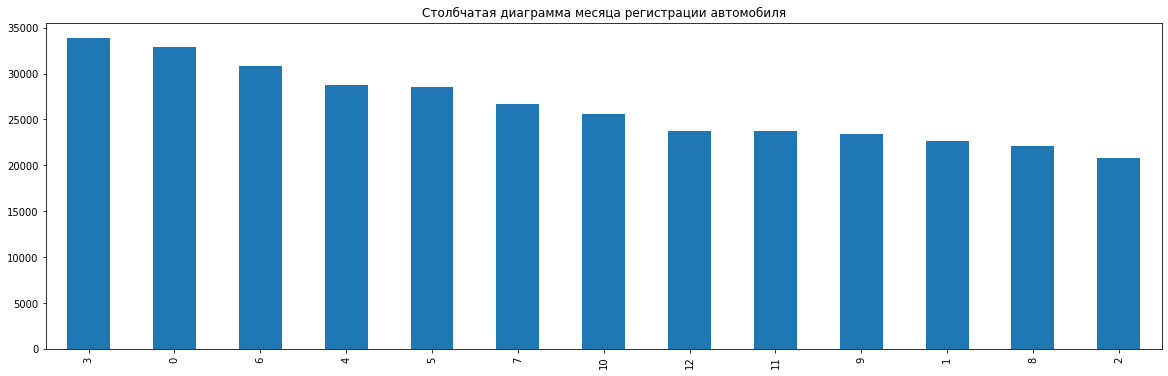

In [ ]:
df['RegistrationMonth'].value_counts().plot(kind = 'bar', 
                                          figsize = (20,6), 
                                          title = 'Столбчатая диаграмма месяца регистрации автомобиля');

In [ ]:
df.loc[df['RegistrationMonth'] == 0, 'RegistrationMonth'].count()

32881

In [ ]:
df.loc[df['RegistrationMonth'] == 0, 'RegistrationMonth'].count()/len(df['RegistrationMonth'])

0.09569752585180723

**10%** данных в столбце с месяцем регистрации равны 0.

#### Численные признаки

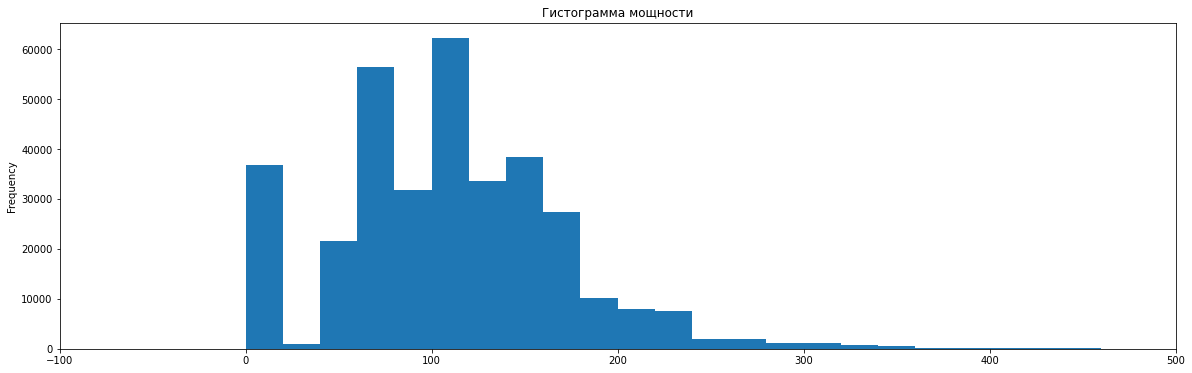

In [ ]:
df['Power'].plot(kind = 'hist', 
                 bins = 1000, 
                 figsize = (20,6), 
                 xlim = (-100, 500), 
                 title = 'Гистограмма мощности');

In [ ]:
df['Power'].describe()

count    343593.000000
mean        110.999665
std         188.178919
min           0.000000
25%          69.000000
50%         105.000000
75%         143.000000
max       20000.000000
Name: Power, dtype: float64

In [ ]:
df.loc[df['Power'] == 0, 'Power'].count()

36360

In [ ]:
df.loc[df['Power'] == 0, 'Power'].count()/len(df['Power'])

0.10582287764884617

In [ ]:
df.loc[(df['Power'] == 0) & (df['RegistrationMonth'] == 0)]

,DateCrawled,Price,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,1993,manual,0,golf,150000,0,petrol,volkswagen,2016-03-24,0,70435,2016-04-07 03:16:57
15,2016-03-11 21:39:15,450,1910,uknown,0,ka,5000,0,petrol,ford,2016-03-11,0,24148,2016-03-19 08:46:47
54,2016-03-17 07:56:40,4700,2005,manual,0,signum,150000,0,uknown,opel,2016-03-17,0,88433,2016-04-04 04:17:32
69,2016-04-01 11:56:40,1200,2001,uknown,0,astra,150000,0,uknown,opel,2016-04-01,0,47249,2016-04-07 08:46:07
94,2016-03-28 16:37:43,8390,2009,uknown,0,insignia,150000,0,uknown,opel,2016-03-28,0,29221,2016-03-30 07:44:59
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
354226,2016-03-14 11:51:40,9000,2008,uknown,0,1er,125000,0,uknown,bmw,2016-03-14,0,93138,2016-04-07 14:57:24
354253,2016-03-25 09:37:59,1250,0,uknown,0,corsa,150000,0,petrol,opel,2016-03-25,0,45527,2016-04-06 07:46:13
354270,2016-04-04 13:55:18,9000,2005,manual,0,a6,150000,0,petrol,audi,2016-04-04,0,99869,2016-04-06 15:16:47
354305,2016-04-03 13:46:24,3500,1995,uknown,0,polo,150000,0,uknown,volkswagen,2016-04-03,0,74579,2016-04-05 12:44:38


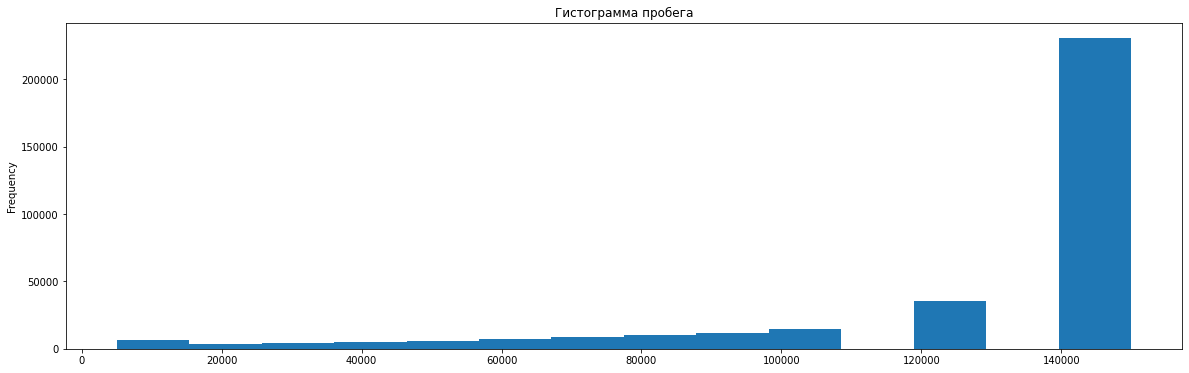

In [ ]:
df['Kilometer'].plot(kind = 'hist', bins = 14,  figsize = (20,6), title = 'Гистограмма пробега');

#### Категориальные признаки

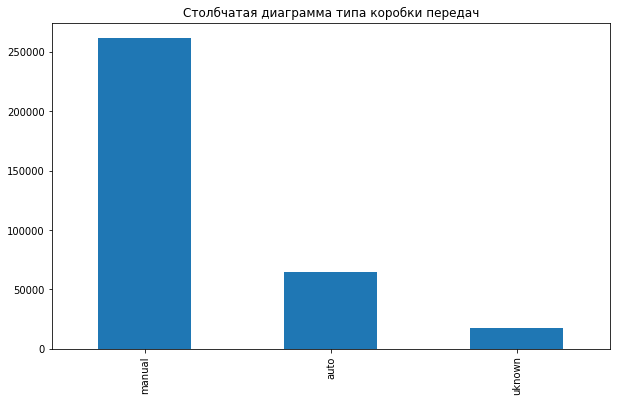

In [ ]:
df['Gearbox'].value_counts().plot(kind = 'bar', 
                                  figsize = (10,6), 
                                  title = 'Столбчатая диаграмма типа коробки передач');

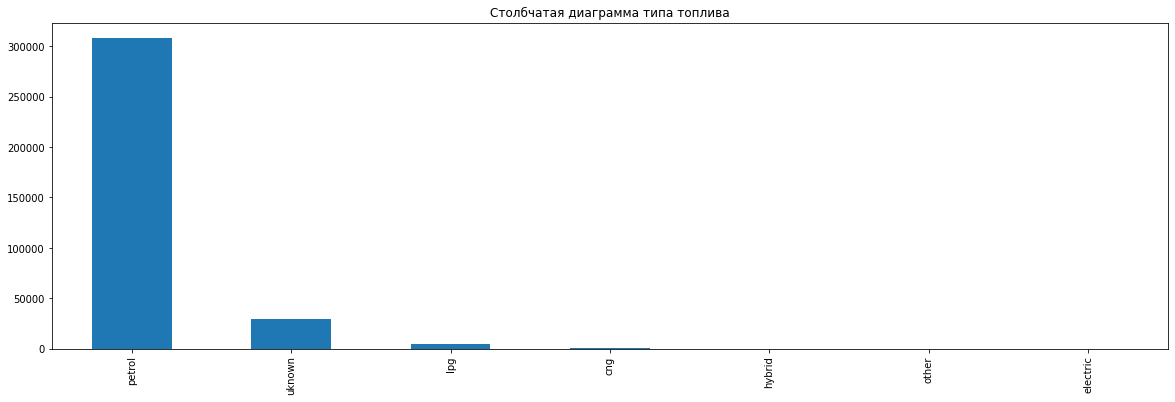

In [ ]:
df['FuelType'].value_counts().plot(kind = 'bar', figsize = (20,6), title = 'Столбчатая диаграмма типа топлива');

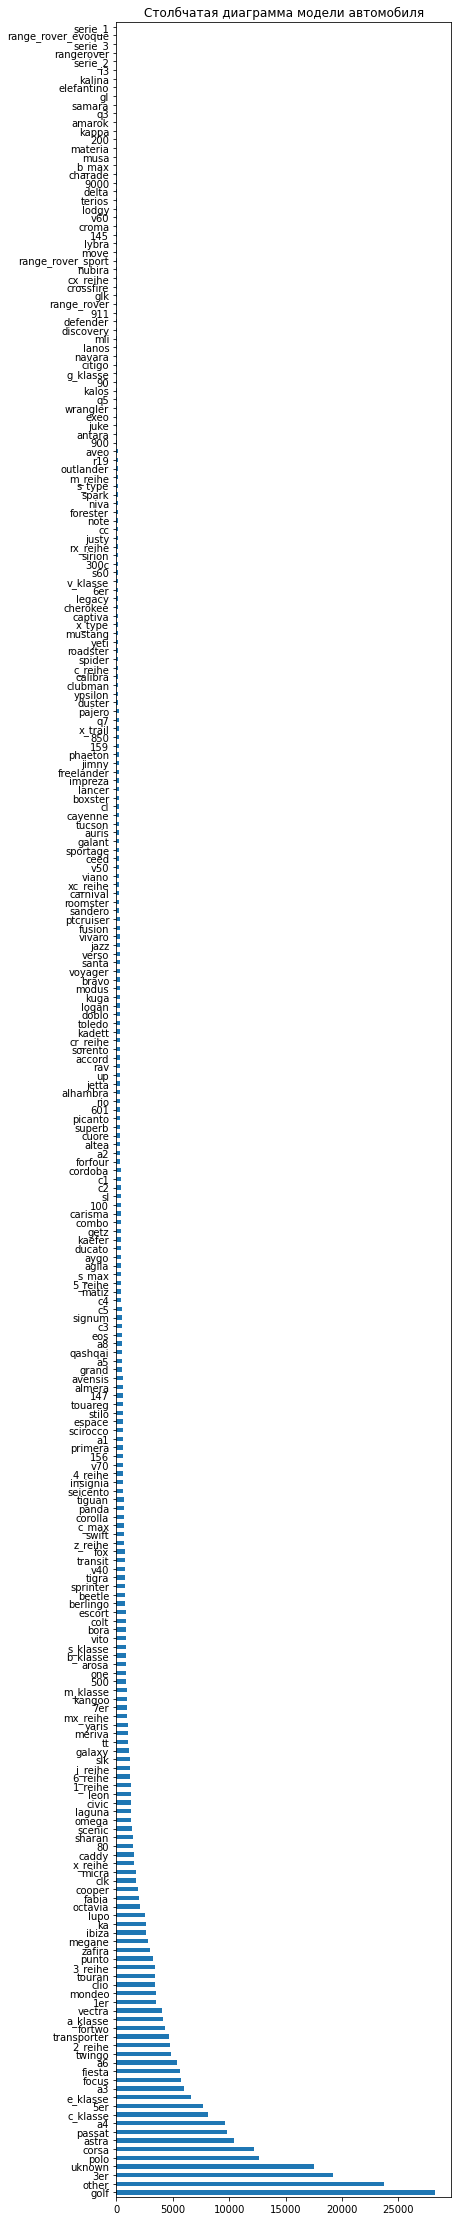

In [ ]:
df['Model'].value_counts().plot(kind = 'barh', 
                                figsize = (6,40),  
                                title = 'Столбчатая диаграмма модели автомобиля');

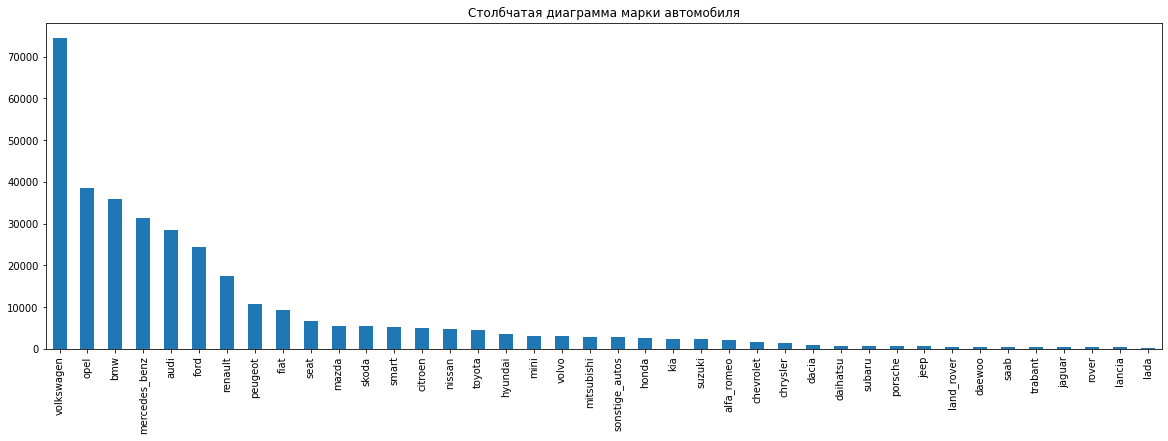

In [ ]:
df['Brand'].value_counts().plot(kind = 'bar', figsize = (20,6), title = 'Столбчатая диаграмма марки автомобиля');

Самая популярная машина **Volkswagen Golf**.

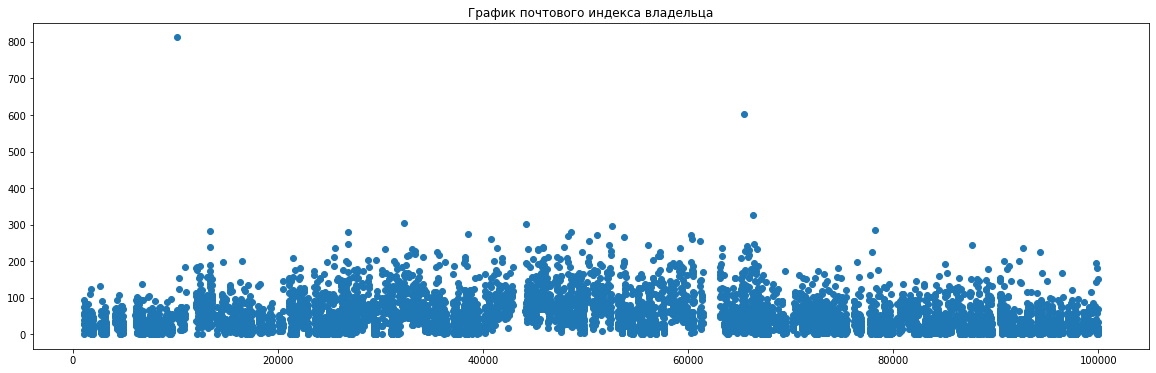

In [ ]:
df['PostalCode'].value_counts().plot(style = 'o', figsize = (20,6), title = 'График почтового индекса владельца');

Индекс указывает на место жительства владельца машины, на регион продажи. Однако в данном датасете почтовых индексов слишком много, чтобы можно было использовать этот признак как категориальный. 

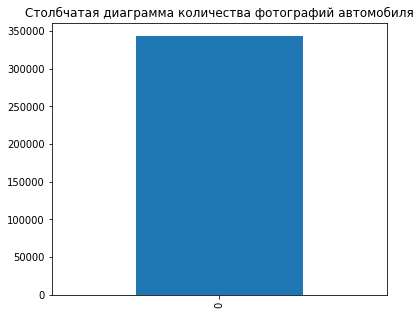

In [ ]:
df['NumberOfPictures'].value_counts().plot(kind = 'bar', figsize = (6,5), title = 'Столбчатая диаграмма количества фотографий автомобиля');

In [ ]:
df['NumberOfPictures'].value_counts()

0    343593
Name: NumberOfPictures, dtype: int64

Фотографий нет.

**Вывод**

Мы поверили данные на наличие дубликатов, пропусков, аномалий и мультиколлинеарности. 

Наличия сильной линейной зависимости между численными признаками не обнаружено.

Среди категориальных ожидаемо обнаружилились сильные взаимосвязи между брендом и моделью и между моделью и типом кузова.

Мы обнаружили и удалили 4 явных дубликата. 

В столбце `FuelType` нашли два разных названия одного и того же вида топлива и привели значения к единоообразию.

Обнаружили **71154** пропусков  в столбце `Repaired`, что составляет более **20%** значений. Информация о том, была ли машина в ремонте важна для предсказания цены. Но узнать ее никак нельзя, а заполнение значениями, рассчитанными на основе других объектов может исказить данные. Поэтому мы удалили этот столбец.

Мы заполнили ячейки с менее **6%** пропусков в столбцах `Model` (32895) и `Gearbox`(19833) и с более **9%** - в столбце `FuelType` значениями **"unknown"**. Удаление строк с пропущенными значениями в этих столбцах привело бы к большой потере данных. 

**37490** пропусков было обнаружено в `VehicleType`, что сотавило более **10%**. Мы удалили этот столбец, так как помимо большого количество пропусков он сильно коррелирует с признаком `Model`, что могло плохо сказаться на качестве модели.

Мы обнаружили **10772** нулевых знаечний в целевом признаке - столбце `Price`. Данные значения составляют всего **3%** данных столбца. Мы удалили строки с такими значениями.

Мы обнаружили и заменили нулями аномальные значения в столбце `RegistrationYear`. Также были обнаружены нулевые значения в столбцах `RegistrationMonth` и `Power`.  

## Обучение моделей

### Подготовка признаков

In [33]:
# Удалим неинформативные признаки, а также признак 'Brand', который сильно коррелирует с 'Model':

df_train = df.drop(['DateCrawled', 
                    'NumberOfPictures', 
                    'DateCreated', 
                    'LastSeen', 
                    'RegistrationMonth',
                    'Brand',
                    'PostalCode'], 
                   axis=1)

In [ ]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 343593 entries, 0 to 354368
Data columns (total 7 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   Price             343593 non-null  int64 
 1   RegistrationYear  343593 non-null  int64 
 2   Gearbox           343593 non-null  object
 3   Power             343593 non-null  int64 
 4   Model             343593 non-null  object
 5   Kilometer         343593 non-null  int64 
 6   FuelType          343593 non-null  object
dtypes: int64(4), object(3)
memory usage: 21.0+ MB


In [34]:
# Разделим на выборки
features_train, features_test, target_train, target_test =\
train_test_split(df_train.drop(['Price'], axis=1), 
                 df_train.Price, 
                 test_size=0.20, 
                 random_state=12345)

In [35]:
# Сохраним категориальные признаки в отдельную переменную
cat_features = ['Gearbox', 'Model', 'FuelType']

In [36]:
# Обозначим численные признаки
num_features = ['RegistrationYear', 'Power', 'Kilometer']

### CatBoostRegressor

In [45]:
# Инициализируем модель CatBoostRegressor с перебором гиперпараметров с помощью функции randomized_search

%time

pool = Pool(data=features_train, label=target_train, cat_features=cat_features)

cb = CatBoostRegressor(random_seed = 12345)

grid = {'learning_rate': [0.03, 0.1],
        'depth': [4, 6, 10],
        'iterations': [150, 250]}

rs_result = cb.grid_search(grid, pool, cv=5, plot = True)

CPU times: user 5 µs, sys: 0 ns, total: 5 µs
Wall time: 9.54 µs


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 6273.9037120	test: 6240.4600253	best: 6240.4600253 (0)	total: 128ms	remaining: 19.1s
1:	learn: 6128.2310710	test: 6095.3542866	best: 6095.3542866 (1)	total: 195ms	remaining: 14.4s
2:	learn: 5986.6150356	test: 5954.5919948	best: 5954.5919948 (2)	total: 249ms	remaining: 12.2s
3:	learn: 5850.5012360	test: 5819.3579374	best: 5819.3579374 (3)	total: 310ms	remaining: 11.3s
4:	learn: 5720.0418587	test: 5689.4689341	best: 5689.4689341 (4)	total: 375ms	remaining: 10.9s
5:	learn: 5591.8024190	test: 5562.0660345	best: 5562.0660345 (5)	total: 425ms	remaining: 10.2s
6:	learn: 5467.8507102	test: 5438.6242909	best: 5438.6242909 (6)	total: 477ms	remaining: 9.74s
7:	learn: 5349.8016758	test: 5321.1751461	best: 5321.1751461 (7)	total: 555ms	remaining: 9.85s
8:	learn: 5235.2130226	test: 5206.9386367	best: 5206.9386367 (8)	total: 614ms	remaining: 9.61s
9:	learn: 5126.2040594	test: 5098.3403204	best: 5098.3403204 (9)	total: 673ms	remaining: 9.43s
10:	learn: 5019.4649296	test: 4992.2847637	best: 4

In [ ]:
cb.get_best_score()

{'learn': {'RMSE': 1809.309741364099}}

In [ ]:
cb.get_params()

{'loss_function': 'RMSE',
 'random_seed': 12345,
 'depth': 10,
 'iterations': 250,
 'learning_rate': 0.1}

### LGBMRegressor

In [ ]:
# Изменим тип данных категориальных признаков на 'category'
lg_features_train = features_train.copy()
lg_features_test = features_test.copy()

for col in lg_features_train.select_dtypes(include=['object']):
    lg_features_train[col] = lg_features_train[col].astype('category') 
    
for col in lg_features_test.select_dtypes(include=['object']):
    lg_features_test[col] = lg_features_test[col].astype('category')     

In [ ]:
# Инициализируем модель LGBMRegressor, 
# настроим гиперпараметры с помощью optuna,
# проверим качество модели на кросс-валидации с помощью cross_val_score

%time

def objective(trial):
    
    learning_rate = trial.suggest_float('learning_rate',  low=0.03, high=0.1, step=0.7)
    n_estimators = trial.suggest_int('n_estimators', 150, 250, 100)
    
    model = lgb.LGBMRegressor(num_leaves=31,  random_seed = 12345)
    
    sc = cross_val_score(model, 
                         lg_features_train, 
                         target_train, 
                         n_jobs = -1, 
                         cv = 5, 
                         scoring = 'neg_root_mean_squared_error')
    
    return np.abs(sc).mean()

study = optuna.create_study(direction ='minimize')
study.optimize(objective, n_trials = 1, show_progress_bar = True)

lgbm_best_learning_rate = study.best_trial.params.get('learning_rate')
lgbm_best_n_estimators = study.best_trial.params.get('n_estimators')
lgbm_best_score = study.best_value

lgbm = lgb.LGBMRegressor(num_leaves=31, 
                         learning_rate = lgbm_best_learning_rate, 
                         n_estimators = lgbm_best_n_estimators,
                         random_seed = 12345)

[I 2023-03-06 09:26:34,190] A new study created in memory with name: no-name-0064aa75-bc61-453f-82f3-a73868982dd6


CPU times: user 5 µs, sys: 0 ns, total: 5 µs
Wall time: 9.54 µs


  0%|          | 0/1 [00:00<?, ?it/s]

[I 2023-03-06 10:01:13,281] Trial 0 finished with value: 1837.171312279701 and parameters: {'learning_rate': 0.03, 'n_estimators': 150}. Best is trial 0 with value: 1837.171312279701.


In [ ]:
lgbm_best_n_estimators

150

In [ ]:
lgbm_best_learning_rate

0.03

In [ ]:
lgbm_best_score

1837.171312279701

### ElasticNet

In [38]:
# Создадим pipeline для стандартизации численных признаков с помощью StandardScaler, 
# кодиврования категориалных признаков с помощью OneHotEncoder
# и модели ElasticNet,
# настроим гиперпараметры и проверим качество модели с помощью кросс-валидации в GridSearchCV

%time

scaler = StandardScaler()

encoder = OneHotEncoder(handle_unknown='ignore', sparse=False)

preprocessing = ColumnTransformer([('num', scaler, num_features), ('cat', encoder, cat_features)])
                                    
elastic = ElasticNet()                                              

pipe = Pipeline(steps=[('preprocess', preprocessing), ('elastic', ElasticNet())])

param_grid = {'elastic__alpha':  [0.2, 0.5, 1],
              'elastic__l1_ratio': [0.2, 0.5, 0.8]}

el = GridSearchCV(pipe, 
                  param_grid = param_grid, 
                  scoring = 'neg_root_mean_squared_error', 
                  n_jobs = -1)

el.fit(features_train, target_train)  

CPU times: user 5 µs, sys: 0 ns, total: 5 µs
Wall time: 45.5 µs


GridSearchCV(estimator=Pipeline(steps=[('preprocess',
                                        ColumnTransformer(transformers=[('num',
                                                                         StandardScaler(),
                                                                         ['RegistrationYear',
                                                                          'Power',
                                                                          'Kilometer']),
                                                                        ('cat',
                                                                         OneHotEncoder(handle_unknown='ignore',
                                                                                       sparse=False),
                                                                         ['Gearbox',
                                                                          'Model',
                                                                          'FuelType'])])),
                                       ('elastic', ElasticNet())]),
             n_jobs=-1,
             param_grid={'elastic__alpha': [0.2, 0.5, 1],
                         'elastic__l1_ratio': [0.2, 0.5, 0.8]},
             scoring='neg_root_mean_squared_error')

In [39]:
el.best_params_

{'elastic__alpha': 0.2, 'elastic__l1_ratio': 0.8}

In [40]:
np.abs(el.best_score_)

3839.4584108683894

## Анализ моделей

Проверим время предсказания каждой модели.

In [ ]:
%%time
cb.predict(features_test)

CPU times: user 173 ms, sys: 2 µs, total: 173 ms
Wall time: 178 ms


array([16376.70783874,  2093.49473723,  2136.2997416 , ...,
        6134.89638663,  2583.67526311,  6694.10284243])

In [ ]:
lgbm.fit(lg_features_train, target_train)

LGBMRegressor(learning_rate=0.03, n_estimators=150, random_seed=12345)

In [ ]:
%%time
lgbm.predict(lg_features_test)

CPU times: user 1.05 s, sys: 0 ns, total: 1.05 s
Wall time: 950 ms


array([16416.31676693,  2090.23265   ,  2119.76181519, ...,
        6198.69070425,  2706.14055823,  6626.64827969])

In [ ]:
%%time
el.predict(features_test)

CPU times: user 43.1 ms, sys: 17.5 ms, total: 60.6 ms
Wall time: 21.3 ms


array([6121.13066162, 3207.38075627, 3475.04189182, ..., 5342.71801659,
       2272.87507395, 5657.62697989])

In [42]:
# Соберем результаты моделей в таблицу
results = pd.DataFrame(index = [['catboost', 'lightGBM', 'elastic']],
                       data = [[1809, 5.96, 0.178], 
                              [1837, 6.44, 0.950], 
                              [3839, 6.68, 0.021]],
                       columns = [['RMSE', 'learning_time', 'prediction_time']])

In [ ]:
results 

,RMSE,learning_time,prediction_time
catboost,1809,5.96,0.178
lightGBM,1837,6.44,0.950
elastic,3855,6.68,0.021


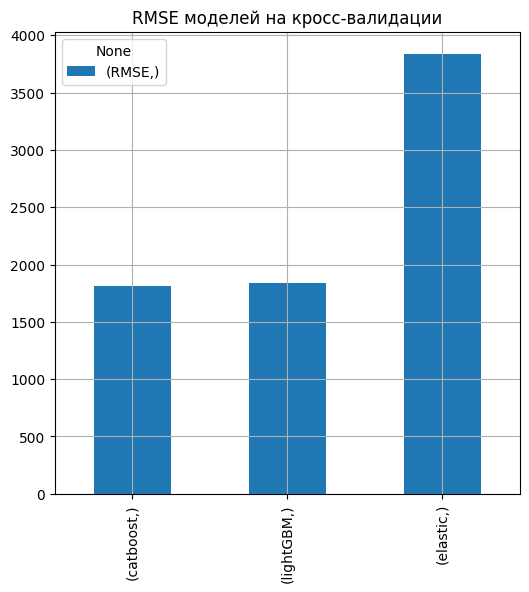

In [43]:
# Построим график RMSE
results['RMSE'].plot(kind = 'bar',
                 grid = True,
                 figsize = (6, 6),
                 title = 'RMSE моделей на кросс-валидации');

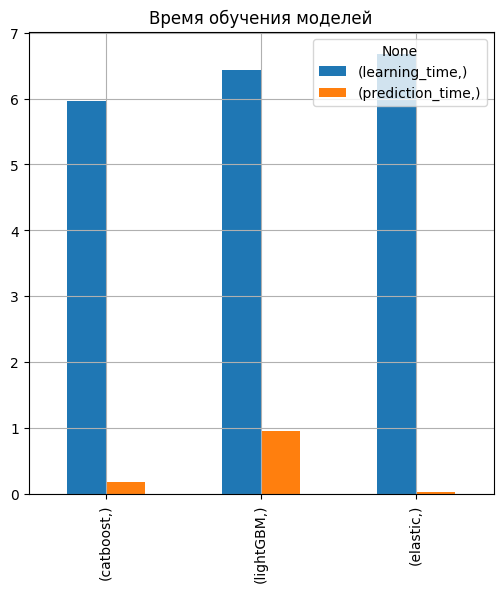

In [44]:
# Построим график RMSE
results[['learning_time', 'prediction_time']].plot(kind = 'bar',
                 grid = True,
                 figsize = (6, 6),
                 title = 'Время обучения моделей');

Лучший результат по качеству предсказания показала модель `CatBoostRegressor` с RMSE **1809**.

По времени обучения эта модель также оказалась быстрее всех - **5.96** м. 

По времени предсказания быстрее всех справилась модель `Elastic` - **0.021** м.

По совокупности критериев лучшая модель - `CatBoostRegressor`

In [46]:
# Протестируем лучшую модель 
predictions_test = cb.predict(features_test)
test_result = mean_squared_error(target_test, predictions_test)**0.5

In [47]:
test_result

1855.647070388566

In [48]:
# Проверим модели на адекватность с помощью DummyRegressor со стратегией 'mean'
dummy_model = DummyRegressor(strategy = 'mean')
dummy_model.fit(features_train, target_train)
predictions_dummy =  dummy_model.predict(features_test)
dummy_result = mean_squared_error(target_test, predictions_dummy)**0.5

In [49]:
dummy_result

4499.902861155948

In [50]:
# Проверим модели на адекватность с помощью DummyRegressor со стратегией 'median'
dummy_model = DummyRegressor(strategy = 'median')
dummy_model.fit(features_train, target_train)
predictions_dummy =  dummy_model.predict(features_test)
dummy_result = mean_squared_error(target_test, predictions_dummy)**0.5

In [51]:
dummy_result

4794.5883773543255

## Общий вывод

Мы проанализировали исторические данные о проданных автомобилях.

Датасет состоял их **354369** строк и **16** столбцов.

На этапе предобработки мы поверили данные на наличие дубликатов, пропусков, аномалий и мультиколлинеарности. 

Сильной линейной зависимости между численными признаками не обнаружено.

Среди категориальных пизаков мы ожидаемо увидели сильные взаимосвязи между брендом и моделью и между моделью и типом кузова. 

Мы обнаружили и удалили 4 явных дубликата. 

В столбце `FuelType` нашли два разных названия одного и того же вида топлива: `petrol` и `gasoline`и заменили все на `petrol`.

Обнаружили **71154** пропусков  в столбце `Repaired`, что составляет более **20%** значений. Информацию о том, была ли машина в ремонте достоверно узнать нельзя, а заполнение значениями, рассчитанными на основе других объектов может исказить данные. Поэтому мы удалили этот столбец.

Мы заполнили ячейки с менее **6%** пропусков в столбцах `Model` (32895) и `Gearbox`(19833) и с более **9%** - в столбце `FuelType` значениями **"unknown"**. 

**37490** пропусков было обнаружено в `VehicleType`, что сотавило более **10%**. Мы удалили этот столбец, так как помимо большого количество пропусков он сильно коррелирует с признаком `Model`, что могло плохо сказаться на качестве модели.

Мы обнаружили **10772** нулевых значений в целевом признаке - столбце `Price`. Данные значения составили всего **3%** данных столбца. Мы удалили строки с такими значениями.

Мы обнаружили нулевые значения в столбцах `RegistrationMonth` и `Power`, а также аномальные значения в столбце `RegistrationYear`, которые мы заменили нулями.  

Мы удалили неинформативные признаки `DateCrawled`, `NumberOfPictures`, `DateCreated`, `LastSeen`, `RegistrationMonth` и `PostalCode`, а также признак `Brand`, который сильно коррелирует с `Model`.

Мы обучили модели `CatBoostRegressor`, `LGBMRegressor`, `ElasticNet` с перебором гиперпараметров и проверкй качества на кросс-валидации.

Лучший результат по метрике RMSE и по времени обучения показала модель `CatBoostRegressor` с RMSE **1809** и временем **5.96** м.

Мы протестировали лучшую модель на тестовой выборке и проверили на адекватность с помощью `DummyRegressor`. 

На тестовой выборке модель `CatBoostRegressor` с параметрами 'depth': 10, 'iterations': 250,
и 'learning_rate': 0.1 показала RMSE **1856**.